In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from interleaver_parameters import *
from interleaver_2_stages import interleaver_2_stage_calc, calculate_spectrum_bandwidth
from interleaver_3_stages import interleaver_3_stage_calc

# Interleaver 2 stages

In [ ]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

dL for 400Ghz FSR:  0.00038810416314973483
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    2.338096 -1.115208  4868.036785
  10    0.498920    0.635000    0.898592    2.484742 -1.065246  4725.710588


In [ ]:
rand_variable_dc1 = np.random.normal(0,random_variable_sigma) 
rand_variable_dc2 = np.random.normal(0,random_variable_sigma) 
rand_variable_dc3 = np.random.normal(0,random_variable_sigma) 

rand_dc1 = (1+rand_variable_dc1)*0.495
rand_dc2 = (1+rand_variable_dc2)*0.630
rand_dc3 = (1+rand_variable_dc3)*0.895

#Clamp values between 0 and 1
rand_dc1 = np.clip(rand_dc1,a_min=0,a_max=1)
rand_dc2 = np.clip(rand_dc2,a_min=0,a_max=1)
rand_dc3 = np.clip(rand_dc3,a_min=0,a_max=1)

variation_interleaver = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = rand_dc1,
    dc2 = rand_dc2,
    dc3 = rand_dc3,
    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[np.random.permutation(2000)[0]],
    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[np.random.permutation(2000)[0]]
)
variation_interleaver.channel_spacing = FSR_wavelength/8

variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]

new_dev_params = [
    rand_dc1,
    rand_dc2,
    rand_dc3,
    interleaver_400Ghz_result.x[3],
    interleaver_400Ghz_result.x[4],
]

wav,bar_port_first_amp,cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)

In [ ]:
Channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9, 80e9]

bandwidth = 1.0
port_amp_dB = 10*np.log10(bar_port_first_amp)
peaks, _ = find_peaks(bar_port_first_amp, height=0.5, distance = 200)
center_index = np.argmin(np.abs(wav[peaks]-center_wavelength))

fsr = np.diff(peaks)

i = 0
center_index_min = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] - int(fsr[center_index-1+i]/2)
center_index_max = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] + int(fsr[center_index+i]/2)

port_amp_dB_local_normalized = port_amp_dB[center_index_min:center_index_max] - np.max(port_amp_dB[center_index_min:center_index_max])
wav_local = wav[center_index_min:center_index_max]

higher_freq = c/wav_local[int(len(port_amp_dB_local_normalized)/2)+np.argmin(np.abs(port_amp_dB_local_normalized[int(len(port_amp_dB_local_normalized)/2):len(port_amp_dB_local_normalized)] + bandwidth))]
lower_freq = c/wav_local[np.argmin(np.abs(port_amp_dB_local_normalized[0:int(len(port_amp_dB_local_normalized)/2)]+ bandwidth))]

## calculating the RF signal spectrum        
plt.figure()
plt.plot((c/wav-(lower_freq/2 + higher_freq/2))/1e9, port_amp_dB, label=f"Interleaver BW={np.abs(lower_freq-higher_freq)/1e9:0.1f}Ghz", color='k')
if i == 0:
    for offset in Channel_offset_list:
        diff_freq = c/wav - (lower_freq/2 + higher_freq/2) + offset
        Tb = 1/(56e9)
        rf_data_before_interleaver = np.array(
            [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
        rf_data_before_interleaver /= np.max(rf_data_before_interleaver)

        rf_data_after_interleaver = rf_data_before_interleaver * bar_port_first_amp
        

        IL_linear = np.sum(rf_data_after_interleaver) / np.sum(rf_data_before_interleaver)
        IL_dB = 10*np.log10(IL_linear)
        plt.plot((c/wav-(lower_freq/2 + higher_freq/2))/1e9, 10*np.log10(rf_data_before_interleaver), label=f'Offset={offset/1e9:0.0f}Ghz, IL={IL_dB:0.2f}dB')
plt.legend(fontsize="10")
plt.xlabel("Relative Freq (Ghz)")
plt.ylabel("Transmission (dB)")
plt.xlim([-250, 250])
plt.ylim([-20, 0 ])

In [ ]:
interleaver_2stages_data = pd.read_csv('interleaver_2_stages.csv')
Channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9, 80e9]
for offset in Channel_offset_list:
    print(f"Ch Offset = {offset/1e9:0.0f}Ghz, Median = ", np.median(interleaver_2stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values), 'dB,1-sigma=', np.std(interleaver_2stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values),'dB, max-loss=', np.min(interleaver_3stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values),'dB')

In [ ]:
fsr_offset = np.array(interleaver_2stages_data['bar_port_center_wavelength_offset_ch1_Ghz'].values) - np.array(interleaver_2stages_data['bar_port_center_wavelength_offset_ch8_Ghz'].values)
print("FSR offset for Bar port: min=",np.min(fsr_offset), "GHz, max ",np.max(fsr_offset), "Ghz, median ", np.median(fsr_offset), "Ghz, 3-sigma ", 3*np.std(fsr_offset),"Ghz")

# Interleaver 3 stages

In [ ]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)

um = 1e-6

 #    DCSplit0    DCSplit1    DCSplit2    phi1        phi2      phi3       Cost    Loss
# 730    0.500906    0.787646    0.821710   -0.425807   0.680199  2.290458   1081.520974, -0.3153106049818951

interleaver_400Ghz_FSR = interleaver_3_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dL3 = 2*dL_400Ghz_FSR,
    dc0 = 0.5,
    dc1 = 0.787,
    dc2 = 0.822,
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8
# interleaver_400Ghz_FSR.phase_shift_1_top = 0.890575
# interleaver_400Ghz_FSR.phase_shift_2_top = 0.919287
# interleaver_400Ghz_FSR.phase_shift_3_top = -0.248552

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

In [ ]:
rand_variable_dc0 = np.random.normal(0,random_variable_sigma) 
rand_variable_dc1 = np.random.normal(0,random_variable_sigma) 
rand_variable_dc2 = np.random.normal(0,random_variable_sigma) 

rand_dc0 = (1+rand_variable_dc0)*0.495000
rand_dc1 = (1+rand_variable_dc1)*0.792000
rand_dc2 = (1+rand_variable_dc2)*0.826348

#Clamp values between 0 and 1
rand_dc0 = np.clip(rand_dc0,a_min=0,a_max=1)
rand_dc1 = np.clip(rand_dc1,a_min=0,a_max=1)
rand_dc2 = np.clip(rand_dc2,a_min=0,a_max=1)

variation_interleaver = interleaver_3_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dL3 = 2*dL_400Ghz_FSR,
    dc0 = 0.5,
    dc1 = 0.85,
    dc2 = 0.945,
    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[np.random.permutation(2000)[0]],
    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[np.random.permutation(2000)[0]]
)
variation_interleaver.dc0._splitratio = rand_dc0
variation_interleaver.dc1._splitratio = rand_dc1
variation_interleaver.dc2._splitratio = rand_dc1
variation_interleaver.dc3._splitratio = rand_dc2
variation_interleaver.channel_spacing = FSR_wavelength/8

variation_interleaver.phase_shift_1_top = interleaver_400Ghz_FSR.phase_shift_1_top
variation_interleaver.phase_shift_2_top = interleaver_400Ghz_FSR.phase_shift_2_top
variation_interleaver.phase_shift_3_top = interleaver_400Ghz_FSR.phase_shift_3_top

new_dev_params = [
    rand_dc0,
    rand_dc1,
    rand_dc2,
    interleaver_400Ghz_FSR.phase_shift_1_top,
    interleaver_400Ghz_FSR.phase_shift_2_top,
    interleaver_400Ghz_FSR.phase_shift_3_top,
]

wav,bar_port_first_amp,cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)

In [ ]:
Channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9, 80e9]

bandwidth = 1.0
port_amp_dB = 10*np.log10(bar_port_first_amp)
peaks, _ = find_peaks(bar_port_first_amp, height=0.5, distance = 200)
center_index = np.argmin(np.abs(wav[peaks]-center_wavelength))

fsr = np.diff(peaks)

i = 0
center_index_min = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] - int(fsr[center_index-1+i]/2)
center_index_max = np.argwhere(wav == wav[peaks][center_index+i]).flatten()[0] + int(fsr[center_index+i]/2)

port_amp_dB_local_normalized = port_amp_dB[center_index_min:center_index_max] - np.max(port_amp_dB[center_index_min:center_index_max])
wav_local = wav[center_index_min:center_index_max]

higher_freq = c/wav_local[int(len(port_amp_dB_local_normalized)/2)+np.argmin(np.abs(port_amp_dB_local_normalized[int(len(port_amp_dB_local_normalized)/2):len(port_amp_dB_local_normalized)] + bandwidth))]
lower_freq = c/wav_local[np.argmin(np.abs(port_amp_dB_local_normalized[0:int(len(port_amp_dB_local_normalized)/2)]+ bandwidth))]

## calculating the RF signal spectrum        
plt.figure()
plt.plot((c/wav-(lower_freq/2 + higher_freq/2))/1e9, port_amp_dB, label=f"Interleaver BW={np.abs(lower_freq-higher_freq)/1e9:0.1f}Ghz", color='k')
if i == 0:
    for offset in Channel_offset_list:
        diff_freq = c/wav - (lower_freq/2 + higher_freq/2) + offset
        Tb = 1/(56e9)
        rf_data_before_interleaver = np.array(
            [0.5 * Tb * (np.sin(np.pi*f*Tb)/(np.pi*f*Tb))**2 for f in diff_freq])
        rf_data_before_interleaver /= np.max(rf_data_before_interleaver)

        rf_data_after_interleaver = rf_data_before_interleaver * bar_port_first_amp
        

        IL_linear = np.sum(rf_data_after_interleaver) / np.sum(rf_data_before_interleaver)
        IL_dB = 10*np.log10(IL_linear)
        plt.plot((c/wav-(lower_freq/2 + higher_freq/2))/1e9, 10*np.log10(rf_data_before_interleaver), label=f'Offset={offset/1e9:0.0f}Ghz, IL={IL_dB:0.2f}dB')
plt.legend(fontsize="10")
plt.xlabel("Relative Freq (Ghz)")
plt.ylabel("Transmission (dB)")
plt.xlim([-250, 250])
plt.ylim([-20, 0 ])

In [ ]:
interleaver_3stages_data = pd.read_csv('interleaver_3_stages.csv')
Channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9, 80e9]
for offset in Channel_offset_list:
    print(f"Ch Offset = {offset/1e9:0.0f}Ghz, Median = ", np.median(interleaver_3stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values), 'dB,1-sigma=', np.std(interleaver_3stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values),'dB, max-loss=', np.min(interleaver_3stages_data[f"insertion_loss_ch_offset_{offset/1e9:0.0f}_Ghz"].values),'dB')

In [ ]:
fsr_offset = np.array(interleaver_3stages_data['bar_port_center_wavelength_offset_ch1_Ghz'].values) - np.array(interleaver_3stages_data['bar_port_center_wavelength_offset_ch8_Ghz'].values)
print("FSR offset for Bar port: min=",np.min(fsr_offset), "GHz, max ",np.max(fsr_offset), "Ghz, median ", np.median(fsr_offset), "Ghz, 3-sigma ", 3*np.std(fsr_offset),"Ghz")

## Plotting Ng, Neff data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
multi_mode_2um = pd.read_csv("gf45clo_sin_neff_ng_variability_v4.csv")

(array([ 14.,   8.,  30.,  72., 209., 249., 153.,  62.,  20.,   4.]),
 array([1.9034714 , 1.91124228, 1.91901316, 1.92678404, 1.93455492,
        1.9423258 , 1.95009668, 1.95786756, 1.96563844, 1.97340932,
        1.9811802 ]),
 <BarContainer object of 10 artists>)

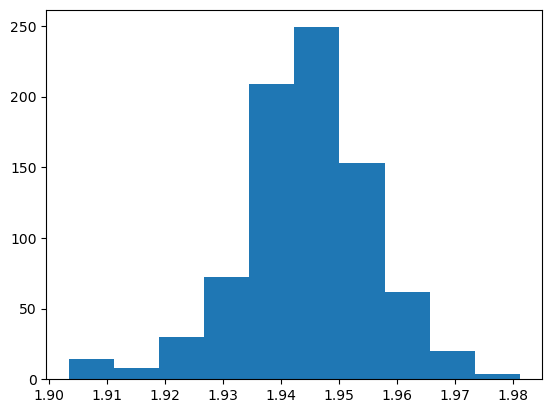

In [2]:
plt.hist(multi_mode_2um['ng_freq0'])

In [3]:
np.std(multi_mode_2um['ng_freq0'])

0.01152821258648021

In [4]:
np.std(multi_mode_2um['neff_freq0'])

0.010893125463506478

In [5]:
np.median(multi_mode_2um['ng_freq0'])

1.9456995

In [6]:
np.median(multi_mode_2um['neff_freq0'])

1.6724